# Notes:

1. Extract data from Port Buffer (Do not re-run)
2. Create Routes p1
3. Create Routes p2 and Validate Vessel Information
4. <b>Update Departures Draught Info</b>
5. Extract to Local
6. Trade Estimation (Local)

Set-up: UNGP - kernel `ais-tt-dev`

For each route, we get the next port visited using the following:

1. get list of imo x mmsi from Port Calls
2. For each vessel, get only the AIS messages that are in between consecutive port calls in the Pacific Islands
3. flag Speed Over Ground (SOG) < 1 to know when the ships stops
4. match with imf Port Boundaries to capture stop within ports.
5. create routes dataset by aggregating by ship stop, polygon routes

Since this will consume a lot of resources, we will use the Global Movements Dataset prepared by ADB instead of the raw AIS data. The Global Movements Dataset (GMD) is the AIS data aggregated by "mpvements" based on whether the ship is stopped or not, within Port Buffer or not, and within Trading passageways (e.g. Suez Canal) or not. The GMD is significantly smaller in size compared to the raw AIS data (+90% reduction in rows) and contains the important information needed to define port calls. However, it is still in its early stages and is subject to revision. The final methodology for the dataset will be part of the supplement to the 2023 Key Indicators for Asia and Pacific publication.  

Warning: Notebook will consume a lot of resources

# Initializers

In [1]:
import os, subprocess, sys

In [2]:
from ais import functions as af

In [3]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import LongType

import h3.api.numpy_int as h3int

In [4]:
import pandas as pd
import geopandas as gpd

from time import time
from datetime import datetime
import json

In [5]:
from shapely.geometry import mapping

In [6]:
pd.set_option('display.max_columns', None) #Show all columns in pandas df
pd.set_option('display.max_rows', 200) #Show 100 rows in pandas df
pd.options.display.float_format = '{:,}'.format #Show float with 10 decimal points in pandas df

from IPython.core.interactiveshell import InteractiveShell #allow multiple outputs in one jupyter cell
InteractiveShell.ast_node_interactivity = "all"

## Variables

In [ ]:
basepath = "s3a://ungp-ais-data-historical-backup/user_temp/"

#all outputs are saved here. when creating your own please change path 
# path = f"{basepath}worldbank/"

s3path = "s3a://ungp-ais-data-historical-backup/user_temp/"
wb_path = f"{s3path}worldbank/"
path_lbn = f"{wb_path}lebanon/"
path_port_calls = f"{wb_path}lebanon_port_calls/"

portcall_path_next = f"{wb_path}lebanon_port_calls_next/"


In [25]:
adb_path = f"{basepath}/adb/"

global_routes_path = f"{adb_path}ki/global_routes_all/"

# Data

## Port Calls

In [27]:
path_port_calls

's3a://ungp-ais-data-historical-backup/user_temp/worldbank/lebanon_port_calls/'

In [28]:
port_calls = pd.read_pickle(f"{path_port_calls}port_calls.pkl")

In [29]:
len(port_calls)

11016

In [30]:
# port_calls = pd.concat([pd.read_pickle(f"{portcall_path}{country}/{year}.pkl") for year in range(2019,2024) for country in country_list], ignore_index=True)
# port_calls.info()
# port_calls.head()

## Port Boundaries

In [31]:
token = "Zskmd5kwe7QywgjWfNTE"
project_id = 358
file_path = "data/AIS_Jasper/port_boundaries.geojson"

string = af.get_file_gitlab(token, project_id, file_path,
                    org_path = "https://code.officialstatistics.org",
                    branch='main',
                    csv_df=False)

imf = gpd.GeoDataFrame.from_features(json.loads(string)).drop_duplicates().rename(columns={'geometry':'port_boundary'}).set_geometry('port_boundary')
imf.info()
imf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1595 entries, 0 to 1594
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   port_boundary  1595 non-null   geometry
 1   Port_name      1595 non-null   object  
 2   Country        1595 non-null   object  
 3   Continent      1595 non-null   object  
dtypes: geometry(1), object(3)
memory usage: 62.3+ KB


port_boundary      Port_name Country  \
0  POLYGON ((-149.93214 61.25829, -149.83906 61.2...      Anchorage  U.S.A.   
1  POLYGON ((-148.68875 60.78098, -148.65289 60.7...       Whittier  U.S.A.   
2  POLYGON ((-146.42760 61.11690, -146.38752 61.1...       Swanport  U.S.A.   
3  POLYGON ((-130.38185 54.34481, -130.24392 54.3...  Prince Rupert  U.S.A.   
4  POLYGON ((-123.13286 49.26700, -123.13218 49.3...      Vancouver  Canada   

       Continent  
0  North-America  
1  North-America  
2  North-America  
3  North-America  
4  North-America

Fix duplicates

Vietnam_Nghe Tinh


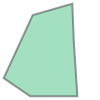

0.022823183564871927

In [32]:
for i in range(1):
    chosen = imf[imf[['Port_name','Country']].duplicated(keep=False)]
    print(f"{chosen['Country'].iloc[i]}_{chosen['Port_name'].iloc[i]}")
    chosen.port_boundary.iloc[i]
    chosen.port_boundary.iloc[i].area

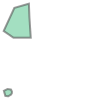

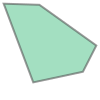

In [33]:
#separate areas same name - get bigger
temp = imf.dissolve(by=['Continent','Port_name','Country']).reset_index()
temp[(temp['Country']=="Vietnam") & (temp['Port_name']=='Nghe Tinh')].iloc[0].port_boundary

#same area,  get bigger
temp = imf.dissolve(by=['Continent','Port_name','Country']).reset_index()
temp[(temp['Country']=="Papua New Guinea") & (temp['Port_name']=='Lae')].iloc[0].port_boundary

In [34]:
imf = imf.drop_duplicates(subset=['Country','Port_name'], keep='first')

# Prep Data

In [35]:
port_calls.head(2)

mmsi         imo        vessel_name  new_route_group    Port  \
0 209,167,000.0 7,359,400.0  SALAMIS FILOXENIA              1.0  Bayrut   
1 209,167,000.0 7,359,400.0  SALAMIS FILOXENIA              2.0  Bayrut   

   length  width vessel_type  arrival_dt_pos_utc  arrival_draught  \
0   157.0   22.0   Passenger 2019-06-08 02:55:42              6.2   
1   157.0   22.0   Passenger 2019-09-22 03:20:42              6.2   

  arrival_destination  count_ais  max_sog  min_sog departure_dt_pos_utc  \
0              BEIRUT       59.0     19.9      0.0  2019-06-09 02:34:42   
1              BEIRUT      109.0     10.5      0.0  2019-09-22 21:03:31   

   departure_draught departure_destination            mean_sog  \
0                6.2               LIMASOL  0.9050847457627119   
1                6.2              LIMASSOL 0.22477064220183487   

       time_spent prev_departure_dt_pos_utc       time_travel  year  month  \
0 0 days 23:39:00                       NaT               NaT  2019      6   
1 0 days 17:42:49       2019-06-09 02:34:42 105 days 00:46:00  2019      9   

        date StatCode5 ShipName         ExName  GrossTonnage  Deadweight  \
0 2019-06-08   A37A2PC    TITAN  Phoenix Titan      15,402.0     3,000.0   
1 2019-09-22   A37A2PC    TITAN  Phoenix Titan      15,402.0     3,000.0   

   LengthOverallLOA  LengthRegistered  TEU  BreadthExtreme  BreadthMoulded  \
0            156.27               0.0  0.0           22.05            22.0   
1            156.27               0.0  0.0           22.05            22.0   

   Displacement  Draught  LightDisplacementTonnage  NetTonnage  \
0      12,127.0     5.92                   9,127.0     6,057.0   
1      12,127.0     5.92                   9,127.0     6,057.0   

     ShiptypeLevel5           ShipTypeLevel4 ShipTypeLevel3  \
0  Passenger/Cruise  Passenger (Cruise) Ship      Passenger   
1  Passenger/Cruise  Passenger (Cruise) Ship      Passenger   

        ShipTypeLevel2  ShiptypeLevel1                          HullType  \
0  Dry Cargo/Passenger  Cargo Carrying  Ship Shape Including Multi-Hulls   
1  Dry Cargo/Passenger  Cargo Carrying  Ship Shape Including Multi-Hulls   

    SubGroup      SubType match_ihs     ihs_imo     ExName_perdate  \
0  Passenger  Cruise Ship       imo 7,359,400.0  Salamis Filoxenia   
1  Passenger  Cruise Ship       imo 7,359,400.0  Salamis Filoxenia   

  ExName_eff_until_date  ihs_mmsi               fin_match       lev_ShipName  \
0            2022-03-01       NaN  okay - match ship name 0.8823529411764706   
1            2022-03-01       NaN  okay - match ship name 0.8823529411764706   

          lev_ExName  lev_ExName_perdate  
0 0.7647058823529411                 0.0  
1 0.7647058823529411                 0.0

In [36]:
port_calls.loc[:, "Country"] = "Lebanon"

In [37]:
#port calls
port_calls = port_calls.reset_index().sort_values(['mmsi','imo','departure_dt_pos_utc']) \
                [['mmsi','imo','arrival_dt_pos_utc','departure_dt_pos_utc','Country','Port','index']] \
                .rename(columns={'mmsi':'pc_mmsi',
                                 'imo':'pc_imo',
                                 'Country':'pc_country',
                                 'Port':'pc_port',
                                 'arrival_dt_pos_utc':'pc_arrival_dt',
                                 'departure_dt_pos_utc':'pc_departure_dt',
                                 'index':'pc_unique_no'
                                })
port_calls['pc_next_arrival_dt'] = port_calls.groupby(['pc_mmsi','pc_imo'])['pc_arrival_dt'].shift(-1).fillna(pd.to_datetime("2023-05-01"))

port_calls.head()

pc_mmsi      pc_imo       pc_arrival_dt     pc_departure_dt  \
0 209,167,000.0 7,359,400.0 2019-06-08 02:55:42 2019-06-09 02:34:42   
1 209,167,000.0 7,359,400.0 2019-09-22 03:20:42 2019-09-22 21:03:31   
2 209,199,000.0 9,461,805.0 2022-01-11 18:07:39 2022-01-16 10:59:15   
3 209,209,000.0 9,528,902.0 2019-04-30 03:19:12 2019-04-30 04:05:26   
4 209,209,000.0 9,528,902.0 2019-05-01 13:26:30 2019-05-02 01:50:51   

  pc_country    pc_port  pc_unique_no  pc_next_arrival_dt  
0    Lebanon     Bayrut             0 2019-09-22 03:20:42  
1    Lebanon     Bayrut             1 2023-05-01 00:00:00  
2    Lebanon  Tarabulus             2 2023-05-01 00:00:00  
3    Lebanon     Bayrut             3 2019-05-01 13:26:30  
4    Lebanon     Bayrut             4 2023-05-01 00:00:00

In [38]:
port_calls['pc_next_arrival_dt'] - port_calls['pc_arrival_dt']

0        106 days 00:25:00
1       1316 days 20:39:18
2        474 days 05:52:21
3          1 days 10:07:18
4       1460 days 10:33:30
               ...        
11011     46 days 20:18:50
11012    537 days 17:20:30
11013     61 days 05:24:50
11014     22 days 09:08:44
11015    481 days 05:06:35
Length: 11016, dtype: timedelta64[ns]

In [39]:
#unique identifier for port calls
port_calls.pc_unique_no.nunique()
port_calls.shape

11016

(11016, 8)

In [40]:
#Spark Dataframe
route_sdf = spark.createDataFrame(port_calls)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [41]:
# route_sdf.count()
# route_sdf.printSchema()

In [42]:
#Port boundaries
#We choose resolution 10 because some polygons are too small to be fitted a lower resolution. 
query_polys = [(f"{imf.Country.iloc[i]}:{imf.Port_name.iloc[i]}",mapping(imf.port_boundary.iloc[i])) for i in range(imf.shape[0])]
len(query_polys)

query_polys[0]

1593

('U.S.A.:Anchorage',
 {'type': 'Polygon',
  'coordinates': (((-149.9321447362291, 61.258287735699795),
    (-149.8390591326616, 61.2586723869542),
    (-149.84713680900424, 61.20020539628371),
    (-149.93829915629968, 61.19828214001165),
    (-149.9321447362291, 61.258287735699795)),)})

In [43]:
imf_df_hex = af.polygon_to_hex_df(query_polys, hex_resolution=10, overfill=False) \
                .rename(columns={'hex_id':'H3_int_index_10','polygon_name':'imf_boundary'}).drop(columns='hex_resolution')
imf_df_hex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6312825 entries, 0 to 6312824
Data columns (total 2 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   H3_int_index_10  int64 
 1   imf_boundary     object
dtypes: int64(1), object(1)
memory usage: 96.3+ MB


In [44]:
imf_df_hex[['Country','Port']] = imf_df_hex['imf_boundary'].str.split(":", expand=True)

In [45]:
imf_df_hex[imf_df_hex.H3_int_index_10.duplicated(keep=False)] #no duplicate h3

Empty DataFrame
Columns: [H3_int_index_10, imf_boundary, Country, Port]
Index: []

In [46]:
imf_df_hex

H3_int_index_10      imf_boundary Country       Port
0        621715773121921023  U.S.A.:Anchorage  U.S.A.  Anchorage
1        621715773474242559  U.S.A.:Anchorage  U.S.A.  Anchorage
2        621715773155475455  U.S.A.:Anchorage  U.S.A.  Anchorage
3        621715773230972927  U.S.A.:Anchorage  U.S.A.  Anchorage
4        621715759079391231  U.S.A.:Anchorage  U.S.A.  Anchorage
...                     ...               ...     ...        ...
6312820  622642287562686463   China:Guangzhou   China  Guangzhou
6312821  622642179456991231   China:Guangzhou   China  Guangzhou
6312822  622642292025425919   China:Guangzhou   China  Guangzhou
6312823  622642288133111807   China:Guangzhou   China  Guangzhou
6312824  622642292020346879   China:Guangzhou   China  Guangzhou

[6312825 rows x 4 columns]

In [47]:
imf_sdf_hex = spark.createDataFrame(imf_df_hex)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


# Process

## Test 1 year using global movements

In [51]:
geo_to_h3 = F.udf(lambda lat, lon: h3int.geo_to_h3(lat, lon, 10), LongType()) 

In [27]:
#stopped at least one hour
#count without at least one hour: 220291921
sdf = spark.read.parquet(global_routes_path+"year=2019") \
        .withColumn("time_hour",(F.col("departure_dt_pos_utc").cast("long")-F.col("arrival_dt_pos_utc").cast("long")) / 3600) \
        .filter((F.col("stopped")==1) & (F.col("time_hour") > 1)) \
        .withColumn("H3_int_index_10",geo_to_h3(F.col("latitude"),F.col("longitude")))
sdf.count()

42566523

In [28]:
sdf2 = sdf \
          .join(F.broadcast(route_sdf),
                  on=(
                        (sdf.mmsi == route_sdf.pc_mmsi) & \
                        (sdf.imo == route_sdf.pc_imo) & \
                        (sdf['arrival_dt_pos_utc'].between(route_sdf.pc_departure_dt, route_sdf.pc_next_arrival_dt))
                        ),
                  how='inner'
               ) \
            .join(imf_sdf_hex, 
                  on="H3_int_index_10", 
                  how="inner"
                 ) \
            .drop('pc_mmsi','pc_imo')
sdf2.count()
# sdf2.show(n=10)
#27524

28389

In [29]:
sdf3 = sdf2.groupBy("pc_unique_no").agg(
        F.min("arrival_dt_pos_utc").alias("arrival_dt_pos_utc"),
        F.min_by("arrival_draught","arrival_dt_pos_utc").alias("arrival_draught"),
        F.min_by("Country","arrival_dt_pos_utc").alias("Country"),
        F.min_by("Port","arrival_dt_pos_utc").alias("Port"),
        F.collect_set(F.col("Country")).alias("country_list")
)
sdf3.cache()

DataFrame[pc_unique_no: bigint, arrival_dt_pos_utc: timestamp, arrival_draught: double, Country: string, Port: string, country_list: array<string>]

In [30]:
sdf3.cache()
sdf3.count() 

DataFrame[pc_unique_no: bigint, arrival_dt_pos_utc: timestamp, arrival_draught: double, Country: string, Port: string, country_list: array<string>]

3118

In [31]:
sdf3.show()

+------------+-------------------+---------------+----------------+----------------+--------------------+
|pc_unique_no| arrival_dt_pos_utc|arrival_draught|         Country|            Port|        country_list|
+------------+-------------------+---------------+----------------+----------------+--------------------+
|       14719|2019-03-15 16:51:40|           10.4|          Taiwan|      Kao Hsiung|[South Korea, Phi...|
|       13098|2019-02-15 04:33:21|            5.8|          U.S.A.|        Honolulu|[French Polynesia...|
|       11745|2019-04-17 05:24:57|            7.4|      Bangladesh|      Chittagong|[Myanmar, Indones...|
|        4823|2019-12-16 20:58:11|            6.0|       Australia|          Darwin|[Australia, Indon...|
|       13248|2019-02-15 00:53:14|            6.1|       Australia|       Melbourne|[Australia, New C...|
|        5556|2019-06-21 14:08:36|            4.0|Papua New Guinea|             Lae|  [Papua New Guinea]|
|       11190|2019-11-24 00:12:42|            

In [32]:
next_pc = sdf3.toPandas()
sdf3.unpersist()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


DataFrame[pc_unique_no: bigint, arrival_dt_pos_utc: timestamp, arrival_draught: double, Country: string, Port: string, country_list: array<string>]

In [33]:
port_calls.merge(next_pc).to_pickle(portcall_path_next+"2019.pkl")

In [34]:
next_df = port_calls.merge(next_pc)

In [35]:
temp = sdf2.filter(F.col("pc_imo") == 8977285) \
    .select("imo","mmsi","arrival_dt_pos_utc","Country","Port","pc_unique_no","pc_next_arrival_dt","pc_departure_dt").toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [36]:
temp.sort_values("arrival_dt_pos_utc")

imo       mmsi  arrival_dt_pos_utc    Country       Port  pc_unique_no  \
0  8977285  205388000 2019-05-02 22:49:11  Singapore  Singapore         10511   
1  8977285  205388000 2019-05-02 22:49:11  Singapore  Singapore         10511   
2  8977285  205388000 2019-05-03 03:11:00  Singapore  Singapore         10511   
3  8977285  205388000 2019-05-03 03:11:00  Singapore  Singapore         10511   

   pc_next_arrival_dt     pc_departure_dt  
0 2019-07-01 23:24:35 2019-01-10 00:28:40  
1 2019-07-01 23:24:35 2019-01-10 00:28:40  
2 2019-07-01 23:24:35 2019-01-10 00:28:40  
3 2019-07-01 23:24:35 2019-01-10 00:28:40

In [37]:
next_df

pc_mmsi   pc_imo       pc_arrival_dt     pc_departure_dt  \
0     205388000  8977285 2019-01-04 11:18:38 2019-01-10 00:28:40   
1     209594000  9435533 2019-08-21 04:21:39 2019-08-22 09:23:34   
2     209594000  9435533 2019-09-30 20:35:04 2019-10-02 21:25:50   
3     209594000  9435533 2019-11-05 20:22:00 2019-11-06 22:32:21   
4     211627240  9633927 2019-01-25 18:59:20 2019-01-28 05:18:21   
...         ...      ...                 ...                 ...   
3113  636091732  9435533 2019-01-24 21:09:12 2019-01-25 23:42:01   
3114  636091732  9435533 2019-02-26 20:33:36 2019-02-28 08:20:01   
3115  636091732  9435533 2019-04-03 20:25:02 2019-04-05 02:00:44   
3116  636092893  9358022 2019-07-02 02:16:27 2019-07-08 09:46:39   
3117  760001110  9144160 2019-02-17 22:48:07 2019-03-17 17:36:00   

            pc_country         pc_port  pc_unique_no  pc_next_arrival_dt  \
0                Palau  Malakal Harbor         10511 2019-07-01 23:24:35   
1     Papua New Guinea             Lae          3078 2019-08-24 00:44:27   
2     Papua New Guinea    Wewak Harbor          3097 2019-10-23 20:01:37   
3     Papua New Guinea    Wewak Harbor          3098 2019-11-29 01:30:13   
4                 Fiji     Suva Harbor             2 2023-05-01 00:00:00   
...                ...             ...           ...                 ...   
3113  Papua New Guinea    Wewak Harbor          7732 2019-02-14 01:22:21   
3114  Papua New Guinea    Wewak Harbor          7733 2019-03-22 01:28:20   
3115  Papua New Guinea    Wewak Harbor          7734 2019-04-27 00:44:38   
3116  Papua New Guinea    Port Moresby          7736 2023-05-01 00:00:00   
3117  Marshall Islands    Majuro Atoll         10460 2023-05-01 00:00:00   

      arrival_dt_pos_utc  arrival_draught           Country             Port  \
0    2019-05-02 22:49:11              2.7         Singapore        Singapore   
1    2019-08-24 00:44:27              7.1  Papua New Guinea     Wewak Harbor   
2    2019-10-11 20:43:39              6.8          Malaysia  Tanjung Pelepas   
3    2019-11-17 02:10:08              7.4          Malaysia  Tanjung Pelepas   
4    2019-02-14 13:57:19              6.6            Mexico       Manzanillo   
...                  ...              ...               ...              ...   
3113 2019-02-02 16:01:41              7.4          Malaysia  Tanjung Pelepas   
3114 2019-03-09 19:11:17              7.2          Malaysia  Tanjung Pelepas   
3115 2019-04-15 13:38:22              7.1          Malaysia  Tanjung Pelepas   
3116 2019-07-23 11:32:04              8.7       South Korea            Ulsan   
3117 2019-04-01 10:35:25              7.8          Thailand         Si Racha   

                                           country_list  
0                                           [Singapore]  
1                                    [Papua New Guinea]  
2                                            [Malaysia]  
3                                            [Malaysia]  
4     [Mexico, Canada, Mauritius, Singapore, Hong Kong]  
...                                                 ...  
3113                                         [Malaysia]  
3114                                         [Malaysia]  
3115                                         [Malaysia]  
3116  [South Korea, United Arab Emirates, Australia,...  
3117                                  [Thailand, India]  

[3118 rows x 13 columns]

## Function

In [52]:
def prep_glob(year):
    sdf = spark.read.parquet(global_routes_path+f"year={year}") \
        .withColumn("time_hour",(F.col("departure_dt_pos_utc").cast("long")-F.col("arrival_dt_pos_utc").cast("long")) / 3600) \
        .filter((F.col("stopped")==1) & (F.col("time_hour") > 1)) \
        .withColumn("H3_int_index_10",geo_to_h3(F.col("latitude"),F.col("longitude")))
    sdf2 = sdf \
          .join(F.broadcast(route_sdf),
                  on=(
                        (sdf.mmsi == route_sdf.pc_mmsi) & \
                        (sdf.imo == route_sdf.pc_imo) & \
                        (sdf['arrival_dt_pos_utc'].between(route_sdf.pc_departure_dt, route_sdf.pc_next_arrival_dt))
                        ),
                  how='inner'
               ) \
            .join(imf_sdf_hex, 
                  on="H3_int_index_10", 
                  how="inner"
                 ) \
            .drop('pc_mmsi','pc_imo')
    sdf3 = sdf2.groupBy("pc_unique_no").agg(
        F.min("arrival_dt_pos_utc").alias("arrival_dt_pos_utc"),
        F.min_by("arrival_draught","arrival_dt_pos_utc").alias("arrival_draught"),
        F.min_by("Country","arrival_dt_pos_utc").alias("Country"),
        F.min_by("Port","arrival_dt_pos_utc").alias("Port"),
        F.collect_set(F.col("Country")).alias("country_list")
    )
    next_pc = sdf3.toPandas()
    next_df = port_calls.merge(next_pc)
    return next_df

## 2019

In [82]:
year=2019
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2194 entries, 0 to 2193
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             2194 non-null   float64       
 1   pc_imo              2194 non-null   float64       
 2   pc_arrival_dt       2194 non-null   datetime64[ns]
 3   pc_departure_dt     2194 non-null   datetime64[ns]
 4   pc_country          2194 non-null   object        
 5   pc_port             2194 non-null   object        
 6   pc_unique_no        2194 non-null   int64         
 7   pc_next_arrival_dt  2194 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  2194 non-null   datetime64[ns]
 9   arrival_draught     2194 non-null   float64       
 10  Country             2194 non-null   object        
 11  Port                2194 non-null   object        
 12  country_list        2194 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [83]:
next_df.to_pickle(portcall_path_next+f"{year}.pkl")

## 2020

In [53]:
year=2020
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2599 entries, 0 to 2598
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             2599 non-null   float64       
 1   pc_imo              2599 non-null   float64       
 2   pc_arrival_dt       2599 non-null   datetime64[ns]
 3   pc_departure_dt     2599 non-null   datetime64[ns]
 4   pc_country          2599 non-null   object        
 5   pc_port             2599 non-null   object        
 6   pc_unique_no        2599 non-null   int64         
 7   pc_next_arrival_dt  2599 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  2599 non-null   datetime64[ns]
 9   arrival_draught     2599 non-null   float64       
 10  Country             2599 non-null   object        
 11  Port                2599 non-null   object        
 12  country_list        2599 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [57]:
portcall_path_next

's3a://ungp-ais-data-historical-backup/user_temp/worldbank/lebanon_port_calls_next/'

In [58]:
next_df.to_pickle(portcall_path_next+f"{year}.pkl")

## 2021

In [59]:
year=2021
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2686 entries, 0 to 2685
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             2686 non-null   float64       
 1   pc_imo              2686 non-null   float64       
 2   pc_arrival_dt       2686 non-null   datetime64[ns]
 3   pc_departure_dt     2686 non-null   datetime64[ns]
 4   pc_country          2686 non-null   object        
 5   pc_port             2686 non-null   object        
 6   pc_unique_no        2686 non-null   int64         
 7   pc_next_arrival_dt  2686 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  2686 non-null   datetime64[ns]
 9   arrival_draught     2686 non-null   float64       
 10  Country             2686 non-null   object        
 11  Port                2686 non-null   object        
 12  country_list        2686 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [60]:
next_df.to_pickle(portcall_path_next+f"{year}.pkl")

## 2022

In [61]:
year=2022
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2777 entries, 0 to 2776
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             2777 non-null   float64       
 1   pc_imo              2777 non-null   float64       
 2   pc_arrival_dt       2777 non-null   datetime64[ns]
 3   pc_departure_dt     2777 non-null   datetime64[ns]
 4   pc_country          2777 non-null   object        
 5   pc_port             2777 non-null   object        
 6   pc_unique_no        2777 non-null   int64         
 7   pc_next_arrival_dt  2777 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  2777 non-null   datetime64[ns]
 9   arrival_draught     2777 non-null   float64       
 10  Country             2777 non-null   object        
 11  Port                2777 non-null   object        
 12  country_list        2777 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [62]:
next_df.to_pickle(portcall_path_next+f"{year}.pkl")

## 2023

In [71]:
year=2023
next_df = prep_glob(year)
next_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393 entries, 0 to 1392
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             1393 non-null   float64       
 1   pc_imo              1393 non-null   float64       
 2   pc_arrival_dt       1393 non-null   datetime64[ns]
 3   pc_departure_dt     1393 non-null   datetime64[ns]
 4   pc_country          1393 non-null   object        
 5   pc_port             1393 non-null   object        
 6   pc_unique_no        1393 non-null   int64         
 7   pc_next_arrival_dt  1393 non-null   datetime64[ns]
 8   arrival_dt_pos_utc  1393 non-null   datetime64[ns]
 9   arrival_draught     1393 non-null   float64       
 10  Country             1393 non-null   object        
 11  Port                1393 non-null   object        
 12  country_list        1393 non-null   object        
dtypes: datetime64[ns](4), float64(3), int64(1), obje

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [78]:
# next_df['pc_next_arrival_dt'].max()

In [79]:
next_df.to_pickle(portcall_path_next+f"{year}.pkl")

## 2023 - using AIS data

In [56]:
sdf = af.get_ais(spark, 
                 start_date = pd.to_datetime("2023-01-01"),
                 end_date = pd.to_datetime("2023-04-30"),
                 columns = ['imo','mmsi','draught','sog','dt_pos_utc', "H3_int_index_10"]
                ).fillna(0, ['imo','mmsi']) \
                .filter((F.col("sog")==1) & ~F.col("latitude").isNull() & ~F.col("longitude").isNull()) \
                .withColumnRenamed("dt_pos_utc","arrival_dt_pos_utc") \
                .withColumnRenamed("draught","arrival_draught")

In [57]:
sdf2 = sdf \
          .join(route_sdf,
                  on=(
                        (sdf.mmsi == route_sdf.pc_mmsi) & \
                        (sdf.imo == route_sdf.pc_imo) & \
                        (sdf['arrival_dt_pos_utc'].between(route_sdf.pc_departure_dt, route_sdf.pc_next_arrival_dt))
                        ),
                  how='inner'
               ) \
            .join(imf_sdf_hex, 
                  on="H3_int_index_10", 
                  how="inner"
                 ) \
            .drop('pc_mmsi','pc_imo') 

w = Window.partitionBy('pc_unique_no')

sdf3 =  sdf2.groupBy("pc_unique_no").agg(
        F.min("arrival_dt_pos_utc").alias("arrival_dt_pos_utc"),
        F.min_by("arrival_draught","arrival_dt_pos_utc").alias("arrival_draught"),
        F.min_by("Country","arrival_dt_pos_utc").alias("Country"),
        F.min_by("Port","arrival_dt_pos_utc").alias("Port"),
        F.collect_set(F.col("Country")).alias("country_list")
)

next_pc = sdf3.toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [58]:
next_df = port_calls.merge(next_pc)
next_df.to_pickle(portcall_path_next+"2023_ext.pkl")

# Merge

In [143]:
next_df = pd.concat([pd.read_pickle(portcall_path_next+f"{year}.pkl") for year in range(2019, 2024)], ignore_index=True)

In [144]:
# next_df = pd.concat([pd.read_pickle(portcall_path_next+f"{year}.pkl") for year in range(2019, 2024)]
#                     + [pd.read_pickle(portcall_path_next + "2023_ext.pkl")], ignore_index=True)

In [145]:
next_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11649 entries, 0 to 11648
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pc_mmsi             11649 non-null  float64       
 1   pc_imo              11649 non-null  float64       
 2   pc_arrival_dt       11649 non-null  datetime64[ns]
 3   pc_departure_dt     11649 non-null  datetime64[ns]
 4   pc_country          11649 non-null  object        
 5   pc_port             11649 non-null  object        
 6   pc_unique_no        11649 non-null  int64         
 7   pc_next_arrival_dt  11649 non-null  datetime64[ns]
 8   arrival_dt_pos_utc  11649 non-null  datetime64[ns]
 9   arrival_draught     11649 non-null  float64       
 10  Country             11649 non-null  object        
 11  Port                11649 non-null  object        
 12  country_list        11649 non-null  object        
dtypes: datetime64[ns](4), float64(3), int64(1), ob

In [146]:
next_df.head()

pc_mmsi      pc_imo       pc_arrival_dt     pc_departure_dt  \
0 209,167,000.0 7,359,400.0 2019-06-08 02:55:42 2019-06-09 02:34:42   
1 209,167,000.0 7,359,400.0 2019-09-22 03:20:42 2019-09-22 21:03:31   
2 209,209,000.0 9,528,902.0 2019-04-30 03:19:12 2019-04-30 04:05:26   
3 209,209,000.0 9,528,902.0 2019-05-01 13:26:30 2019-05-02 01:50:51   
4 209,890,000.0 9,256,028.0 2019-10-11 05:28:24 2019-10-12 05:19:14   

  pc_country pc_port  pc_unique_no  pc_next_arrival_dt  arrival_dt_pos_utc  \
0    Lebanon  Bayrut             0 2019-09-22 03:20:42 2019-06-09 12:49:18   
1    Lebanon  Bayrut             1 2023-05-01 00:00:00 2019-09-23 06:51:07   
2    Lebanon  Bayrut             3 2019-05-01 13:26:30 2019-05-01 13:26:30   
3    Lebanon  Bayrut             4 2023-05-01 00:00:00 2019-05-15 17:16:51   
4    Lebanon   Sayda            11 2023-05-01 00:00:00 2019-12-11 20:56:20   

   arrival_draught              Country                   Port  \
0              6.2               Cyprus               Limassol   
1              6.2               Cyprus               Limassol   
2              5.0              Lebanon                 Bayrut   
3              5.2                Italy  Porto Di Lido-Venezia   
4             12.6  U.S. Virgin Islands           Limetree Bay   

                                        country_list  
0                           [Greece, Israel, Cyprus]  
1  [Italy, Greece, Montenegro, Israel, Egypt, Cyp...  
2                                          [Lebanon]  
3  [Italy, Germany, United Kingdom, Malta, Spain,...  
4                      [U.S. Virgin Islands, U.S.A.]

In [147]:
next_df['pc_unique_no'].nunique()

7744

In [148]:
next_df = next_df[['pc_mmsi','pc_imo','pc_unique_no','Country','Port','arrival_dt_pos_utc','arrival_draught','country_list']] \
        .sort_values(["pc_unique_no","arrival_dt_pos_utc"], ignore_index=True) \
        .drop_duplicates(subset=['pc_unique_no'],keep='first', ignore_index=True) \
        .rename(columns={'pc_mmsi':'mmsi',
                 'pc_imo':'imo',
                 'pc_unique_no':'index',
                 'Country':'next_Country',
                 'Port':'next_Port',
                 'arrival_dt_pos_utc':'next_arrival_dt',
                 'arrival_draught':'next_arrival_draught'}) 

In [149]:
next_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744 entries, 0 to 7743
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   mmsi                  7744 non-null   float64       
 1   imo                   7744 non-null   float64       
 2   index                 7744 non-null   int64         
 3   next_Country          7744 non-null   object        
 4   next_Port             7744 non-null   object        
 5   next_arrival_dt       7744 non-null   datetime64[ns]
 6   next_arrival_draught  7744 non-null   float64       
 7   country_list          7744 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 484.1+ KB


In [150]:
port_calls = pd.read_pickle(f"{path_port_calls}port_calls.pkl")

In [151]:
len(next_df)

7744

In [152]:
len(port_calls)

11016

In [153]:
next_df

mmsi         imo  index next_Country              next_Port  \
0    209,167,000.0 7,359,400.0      0       Cyprus               Limassol   
1    209,167,000.0 7,359,400.0      1       Cyprus               Limassol   
2    209,199,000.0 9,461,805.0      2      Romania              Constanta   
3    209,209,000.0 9,528,902.0      3      Lebanon                 Bayrut   
4    209,209,000.0 9,528,902.0      4        Italy  Porto Di Lido-Venezia   
...            ...         ...    ...          ...                    ...   
7739 750,332,000.0 8,408,650.0  11011     Bulgaria                 Burgas   
7740 750,332,000.0 8,408,650.0  11012       Turkey                Yakacik   
7741 750,994,000.0 9,136,852.0  11013        Egypt               Damietta   
7742 750,994,000.0 9,136,852.0  11014      Lebanon                 Bayrut   
7743 750,994,000.0 9,136,852.0  11015        Egypt               Damietta   

         next_arrival_dt  next_arrival_draught  \
0    2019-06-09 12:49:18                   6.2   
1    2019-09-23 06:51:07                   6.2   
2    2022-01-29 01:39:54                   6.9   
3    2019-05-01 13:26:30                   5.0   
4    2019-05-15 17:16:51                   5.2   
...                  ...                   ...   
7739 2021-10-13 09:24:03                   8.7   
7740 2021-11-16 17:41:46                   7.9   
7741 2021-10-19 03:54:20                   7.4   
7742 2022-01-04 18:53:25                   4.0   
7743 2022-01-10 18:23:19                   4.0   

                                           country_list  
0                              [Greece, Israel, Cyprus]  
1     [Italy, Greece, Montenegro, Israel, Egypt, Cyp...  
2     [Algeria, Jordan, Brazil, Cameroon, Namibia, A...  
3                                             [Lebanon]  
4     [Italy, Germany, United Kingdom, Malta, Spain,...  
...                                                 ...  
7739                        [Ukraine, Turkey, Bulgaria]  
7740                           [Turkey, Romania, Egypt]  
7741                           [Ukraine, Turkey, Egypt]  
7742                                          [Lebanon]  
7743                            [Greece, Turkey, Egypt]  

[7744 rows x 8 columns]

In [142]:
# port_calls = pd.concat([pd.read_pickle(f"{portcall_path}{country}/{year}.pkl") for year in range(2019,2024) for country in country_list], ignore_index=True) \
#                 .reset_index()

In [155]:
# port_calls

In [192]:
port_calls_v2 = port_calls.merge(next_df, how='left', right_on='index', left_index=True, suffixes=('', 'next'))
# port_calls_v2.info()

In [193]:
port_calls_v2.head(2)

mmsi         imo        vessel_name  new_route_group    Port  \
0.0 209,167,000.0 7,359,400.0  SALAMIS FILOXENIA              1.0  Bayrut   
1.0 209,167,000.0 7,359,400.0  SALAMIS FILOXENIA              2.0  Bayrut   

     length  width vessel_type  arrival_dt_pos_utc  arrival_draught  \
0.0   157.0   22.0   Passenger 2019-06-08 02:55:42              6.2   
1.0   157.0   22.0   Passenger 2019-09-22 03:20:42              6.2   

    arrival_destination  count_ais  max_sog  min_sog departure_dt_pos_utc  \
0.0              BEIRUT       59.0     19.9      0.0  2019-06-09 02:34:42   
1.0              BEIRUT      109.0     10.5      0.0  2019-09-22 21:03:31   

     departure_draught departure_destination            mean_sog  \
0.0                6.2               LIMASOL  0.9050847457627119   
1.0                6.2              LIMASSOL 0.22477064220183487   

         time_spent prev_departure_dt_pos_utc       time_travel  year  month  \
0.0 0 days 23:39:00                       NaT               NaT  2019      6   
1.0 0 days 17:42:49       2019-06-09 02:34:42 105 days 00:46:00  2019      9   

          date StatCode5 ShipName         ExName  GrossTonnage  Deadweight  \
0.0 2019-06-08   A37A2PC    TITAN  Phoenix Titan      15,402.0     3,000.0   
1.0 2019-09-22   A37A2PC    TITAN  Phoenix Titan      15,402.0     3,000.0   

     LengthOverallLOA  LengthRegistered  TEU  BreadthExtreme  BreadthMoulded  \
0.0            156.27               0.0  0.0           22.05            22.0   
1.0            156.27               0.0  0.0           22.05            22.0   

     Displacement  Draught  LightDisplacementTonnage  NetTonnage  \
0.0      12,127.0     5.92                   9,127.0     6,057.0   
1.0      12,127.0     5.92                   9,127.0     6,057.0   

       ShiptypeLevel5           ShipTypeLevel4 ShipTypeLevel3  \
0.0  Passenger/Cruise  Passenger (Cruise) Ship      Passenger   
1.0  Passenger/Cruise  Passenger (Cruise) Ship      Passenger   

          ShipTypeLevel2  ShiptypeLevel1                          HullType  \
0.0  Dry Cargo/Passenger  Cargo Carrying  Ship Shape Including Multi-Hulls   
1.0  Dry Cargo/Passenger  Cargo Carrying  Ship Shape Including Multi-Hulls   

      SubGroup      SubType match_ihs     ihs_imo     ExName_perdate  \
0.0  Passenger  Cruise Ship       imo 7,359,400.0  Salamis Filoxenia   
1.0  Passenger  Cruise Ship       imo 7,359,400.0  Salamis Filoxenia   

    ExName_eff_until_date  ihs_mmsi               fin_match  \
0.0            2022-03-01       NaN  okay - match ship name   
1.0            2022-03-01       NaN  okay - match ship name   

          lev_ShipName         lev_ExName  lev_ExName_perdate      mmsinext  \
0.0 0.8823529411764706 0.7647058823529411                 0.0 209,167,000.0   
1.0 0.8823529411764706 0.7647058823529411                 0.0 209,167,000.0   

        imonext  index next_Country next_Port     next_arrival_dt  \
0.0 7,359,400.0      0       Cyprus  Limassol 2019-06-09 12:49:18   
1.0 7,359,400.0      1       Cyprus  Limassol 2019-09-23 06:51:07   

     next_arrival_draught                                       country_list  
0.0                   6.2                           [Greece, Israel, Cyprus]  
1.0                   6.2  [Italy, Greece, Montenegro, Israel, Egypt, Cyp...

In [194]:
len(port_calls)

11016

In [195]:
# port_calls_v2[['country_list','Country']].iloc[1][0]

In [196]:
# port_calls_v2

In [197]:
port_calls_v2['country_list']

0.0                                 [Greece, Israel, Cyprus]
1.0        [Italy, Greece, Montenegro, Israel, Egypt, Cyp...
2.0        [Algeria, Jordan, Brazil, Cameroon, Namibia, A...
3.0                                                [Lebanon]
4.0        [Italy, Germany, United Kingdom, Malta, Spain,...
                                 ...                        
7,739.0                          [Ukraine, Turkey, Bulgaria]
7,740.0                             [Turkey, Romania, Egypt]
7,741.0                             [Ukraine, Turkey, Egypt]
7,742.0                                            [Lebanon]
7,743.0                              [Greece, Turkey, Egypt]
Name: country_list, Length: 11016, dtype: object

In [198]:
port_calls_v2.loc[:, "Country"] = "Lebanon"

In [199]:
#remove port country in country_list
cond = ~port_calls_v2['country_list'].isnull()
port_calls_v2.loc[cond, 'country_list2'] = port_calls_v2.loc[cond, ["country_list","Country"]].apply(lambda x: [j for j in x[0] if j != x[1]], axis=1)

#remove American Samoa, Samoa in country_list if port country is American Samoa, Samoa
cond = ~port_calls_v2['country_list'].isnull() & port_calls_v2['Country'].isin(["Samoa","American Samoa"])
port_calls_v2.loc[cond, 'country_list2'] = port_calls_v2.loc[cond, ["country_list","Country"]].apply(lambda x: [j for j in x[0] if j not in ['American Samoa','Samoa']], axis=1)

port_calls_v2['country_count'] = port_calls_v2['country_list2'].fillna("").apply(lambda x: len(x))

In [200]:
port_calls_v2['country_count'].describe()

count             11,016.0
mean    2.7854030501089326
std     3.5432954444255524
min                    0.0
25%                    0.0
50%                    2.0
75%                    4.0
max                   32.0
Name: country_count, dtype: float64

In [201]:
# port_calls_v2[port_calls_v2['country_count']==0]

In [202]:
next_df[next_df['country_list'].isnull()].next_arrival_dt.describe()

/tmp/ipykernel_51/1974707498.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  next_df[next_df['country_list'].isnull()].next_arrival_dt.describe()


count       0
unique      0
top       NaN
freq      NaN
Name: next_arrival_dt, dtype: object

In [203]:
port_calls_v2[['country_list','Country']].iloc[1]

country_list    [Italy, Greece, Montenegro, Israel, Egypt, Cyp...
Country                                                   Lebanon
Name: 1.0, dtype: object

In [204]:
path_port_calls

's3a://ungp-ais-data-historical-backup/user_temp/worldbank/lebanon_port_calls/'

In [205]:
port_calls_v2.to_pickle(f"{path_port_calls}port_calls_w_backprop.pkl")

## Download to local

In [206]:
df = port_calls_v2.copy()

In [207]:
keep_cols = [
'Country',
'Port',
'mmsi',
'imo',
'length',
'width',
'vessel_name',
'arrival_dt_pos_utc',
'arrival_draught',
'arrival_destination',
'count_ais',
'departure_dt_pos_utc',
'departure_draught',
'departure_destination',
'year',
'month',
'week',
'date',
'StatCode5',
'GrossTonnage',
'Deadweight',
'LengthOverallLOA',
'TEU',
'BreadthMoulded',
'Displacement',
'Draught',
'LightDisplacementTonnage',
'NetTonnage',
'ShiptypeLevel5',
'ShipTypeLevel4',
'ShipTypeLevel3',
'ShipTypeLevel2',
'ShiptypeLevel1',
'next_Country',
'next_Port',
'next_arrival_draught',
'next_arrival_dt',
'country_count',
'LengthRegistered',
'BreadthExtreme',
'SubType',
'SubGroup'
]


In [208]:
df['week'] =df['date'].dt.isocalendar().week

In [209]:
country = "Lebanon"

In [210]:
len(df)

11016

In [211]:
file = f"{country}.csv"

# Uncomment to download
af.create_download_link(df[keep_cols], file, file)

In [120]:
# for country in country_list:
#     for year in range(2019,2024):
#         port_calls_v2[(port_calls_v2['Country']==country) & (port_calls_v2['year']==year)].reset_index(drop=True) \
#             .to_pickle(port_call_w_backprop+f"{country}/{year}.pkl")

In [121]:
# port_calls_v2.groupby(['mmsi','imo'])['country_count'].mean().describe()

In [75]:
spark.stop()